In [1]:
import torch
from torch_geometric.data import Data
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [2]:
df = pd.read_csv("C:/Users/admin/Desktop/random.csv")  # 로컬에 저장된 CSV 경로

# 1. 기지국 노드 생성
base_stations = df.copy() 
base_stations["type"] = 0  # type 0 = 기지국
base_stations_features = base_stations[["x", "y", "radius"]].values
num_base_stations = len(base_stations)

# 2. 격자 노드 생성 (10m 간격) 총 10,000개 생성
grid_x, grid_y = np.meshgrid(np.arange(0, 1000, 10), np.arange(0, 1000, 10))
grid_coords = np.stack((grid_x.ravel(), grid_y.ravel()), axis=1)
num_grids = len(grid_coords)

grid_radii = np.zeros((num_grids, 1))
grid_features = np.hstack((grid_coords, grid_radii))
grid_types = np.ones((num_grids, 1))  # type 1 = 격자점

# 3. 전체 노드 결합
all_features = np.vstack((base_stations_features, grid_features)) # (10003,3)
all_types = np.vstack((base_stations["type"].values.reshape(-1, 1), grid_types))

x = torch.tensor(all_features, dtype=torch.float) # tensor로 변환시켜주기 
node_type = torch.tensor(all_types, dtype=torch.long).squeeze()

# 4. 엣지 연결: 기지국 ↔ 커버 가능한 격자점
edge_index_list = []

# 기지국의 위치와 격자점 사이의 거리가 반경 안에 들어오면 엣지 하나 생성
for i, (bx, by, br) in enumerate(base_stations_features):
    distances = np.sqrt((grid_coords[:, 0] - bx) ** 2 + (grid_coords[:, 1] - by) ** 2)
    covered_indices = np.where(distances <= br)[0]
    for j in covered_indices:
        edge_index_list.append([i, num_base_stations + j])  # 기지국 → 격자점

# edge_index 생성 (기지국 = 0, 1, 2 니까 격자점 인덱스는 3부터 시작)
edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

# PyTorch Geometric Data 객체 생성
data = Data(x=x, edge_index=edge_index) # x=(x,y,반경) , edge_index=그래프의 엣지 목록
data.num_base_stations = num_base_stations
data.num_grids = num_grids
data.node_type = node_type

data

print(data.x[:5])          # 앞의 몇 개 노드 특성 (기지국들)
print(data.edge_index[:, :5])  # 앞의 몇 개 엣지
print(data.node_type[:10])     # 노드 타입 정보 (0, 0, 0, 1, 1, ...)

tensor([[100., 500., 700.],
        [900., 500., 700.],
        [500., 250., 200.],
        [  0.,   0.,   0.],
        [ 10.,   0.,   0.]])
tensor([[0, 0, 0, 0, 0],
        [3, 4, 5, 6, 7]])
tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 1])


In [3]:
# import matplotlib.pyplot as plt

# # 기지국 좌표
# base_coords = base_stations_features[:, :2]
# # 격자점 좌표
# grid_coords = grid_features[:, :2]

# # 엣지 시각화를 위한 위치 변환
# edge_index_np = edge_index.numpy()
# edges = edge_index_np.T  # (E, 2)

# plt.figure(figsize=(10, 10))

# # 격자점 시각화
# plt.scatter(grid_coords[:, 0], grid_coords[:, 1], s=1, color='blue', label="Grid Point")

# # 기지국 시각화
# plt.scatter(base_coords[:, 0], base_coords[:, 1], s=100, color='red', marker='o', label="Base Station")

# # 엣지 시각화 (기지국 → 격자점)
# for src, dst in edges[::100]:  # 너무 많으니 일부만 표시
#     x0, y0 = all_features[src][:2]
#     x1, y1 = all_features[dst][:2]
#     plt.plot([x0, x1], [y0, y1], color='gray', linewidth=0.2)

# plt.legend()
# plt.title("Graph Representation: Base Stations → Covered Grid Points")
# plt.xlim(0, 1000)
# plt.ylim(0, 1000)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.grid(True)
# plt.show()

# print(f"총 노드 수: {data.num_nodes}")  # 기지국 + 격자점
# print(f"총 엣지 수: {data.edge_index.shape[1]}")  # 전체 엣지 개수
# print(f"기지국당 평균 연결 수: {data.edge_index.shape[1] // data.num_base_stations}")


In [4]:
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F

class GNNSelector(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, normalize=False)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, normalize=False)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(hidden_channels, 1)

        # 초기 weight/bias
        nn.init.constant_(self.out.bias, 0.0)

    def forward(self, x, edge_index, node_type):
        h = self.conv1(x, edge_index)
        h = self.bn1(h)
        h = F.relu(h)
        h = self.dropout(h)

        h = self.conv2(h, edge_index)
        h = self.bn2(h)
        h = F.relu(h)
        h = self.dropout(h)

        base_mask = (node_type == 0)
        base_h = h[base_mask]  # (num_base_stations, hidden)
        logits = self.out(base_h).squeeze(-1)  # shape: (num_base_stations,)

        prob = F.softmax(logits, dim=0)  # softmax로 정규화
        return prob

In [5]:
from torch_scatter import scatter_add

def compute_coverage_loss_softmax(prob, edge_index, num_base_stations, num_grids, alpha=1.0):
    device = prob.device
    base_indices = edge_index[0]
    grid_indices = edge_index[1] - num_base_stations  # 격자점 인덱스 정렬

    # 확률 기반 커버리지 합산 (soft coverage)
    coverage_sum = scatter_add(prob[base_indices], grid_indices, dim=0, dim_size=num_grids)
    grid_coverage = torch.clamp(coverage_sum, max=1.0)

    # uncovered loss: 1.0 - 커버율
    uncovered_loss = 1.0 - grid_coverage
    uncovered_ratio = uncovered_loss.mean()

    # softmax 기반에서는 selected_ratio는 항상 1이므로 의미가 약함
    loss = uncovered_ratio + alpha * (prob ** 2).sum()  # sparsity 유도 (확률 제곱합 최소화)
    return loss, uncovered_ratio.item()


In [6]:
def train_softmax(model, data, alpha=1.0, num_epochs=300, lr=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()

        prob = model(data.x, data.edge_index, data.node_type)  # softmax 확률 (합 1)

        loss, uncovered_ratio = compute_coverage_loss_softmax(
            prob, data.edge_index, data.num_base_stations, data.num_grids, alpha=alpha
        )

        loss.backward()
        optimizer.step()

        if epoch % 10 == 0 or epoch == 1:
            print(f"[Epoch {epoch:03d}] Loss: {loss.item():.4f} | Uncovered: {uncovered_ratio:.4f}")

    return model


In [7]:
model = GNNSelector(in_channels=3, hidden_channels=64)
trained_model = train_softmax(model, data, alpha=1.0, num_epochs=300)


[Epoch 001] Loss: 0.7669 | Uncovered: 0.3985
[Epoch 010] Loss: 0.8106 | Uncovered: 0.4759
[Epoch 020] Loss: 0.7859 | Uncovered: 0.4051
[Epoch 030] Loss: 0.7583 | Uncovered: 0.4091
[Epoch 040] Loss: 0.7688 | Uncovered: 0.3792
[Epoch 050] Loss: 0.8751 | Uncovered: 0.4543
[Epoch 060] Loss: 0.8187 | Uncovered: 0.4831
[Epoch 070] Loss: 0.8274 | Uncovered: 0.4902
[Epoch 080] Loss: 0.7870 | Uncovered: 0.4525
[Epoch 090] Loss: 0.8114 | Uncovered: 0.4770
[Epoch 100] Loss: 0.8167 | Uncovered: 0.4797
[Epoch 110] Loss: 0.7709 | Uncovered: 0.4319
[Epoch 120] Loss: 0.8961 | Uncovered: 0.5273
[Epoch 130] Loss: 0.7919 | Uncovered: 0.4230
[Epoch 140] Loss: 0.8781 | Uncovered: 0.5293
[Epoch 150] Loss: 0.7776 | Uncovered: 0.4054
[Epoch 160] Loss: 0.7779 | Uncovered: 0.4166
[Epoch 170] Loss: 0.8092 | Uncovered: 0.4727
[Epoch 180] Loss: 0.7777 | Uncovered: 0.4340
[Epoch 190] Loss: 0.8014 | Uncovered: 0.4605
[Epoch 200] Loss: 0.7784 | Uncovered: 0.4175
[Epoch 210] Loss: 0.8302 | Uncovered: 0.4942
[Epoch 220

In [8]:
trained_model.eval()
with torch.no_grad():
    prob = trained_model(data.x, data.edge_index, data.node_type)  # shape: (num_base_stations,)
    print("📌 각 기지국 선택 확률:")
    for i, p in enumerate(prob.tolist()):
        print(f"기지국 {i}: 선택 확률 = {p:.4f}")


📌 각 기지국 선택 확률:
기지국 0: 선택 확률 = 0.3333
기지국 1: 선택 확률 = 0.3333
기지국 2: 선택 확률 = 0.3333


In [9]:
with torch.no_grad():
    prob = model(data.x, data.edge_index, data.node_type)  # shape: (num_base_stations,)
    selected = (prob > 0.6).float()  # 확률이 0.5 초과인 기지국만 선택
    selected_indices = selected.nonzero(as_tuple=True)[0].cpu().numpy()
    print(f"선택된 기지국 수: {len(selected_indices)}")
    print(f"선택된 기지국 인덱스: {selected_indices}")

선택된 기지국 수: 0
선택된 기지국 인덱스: []


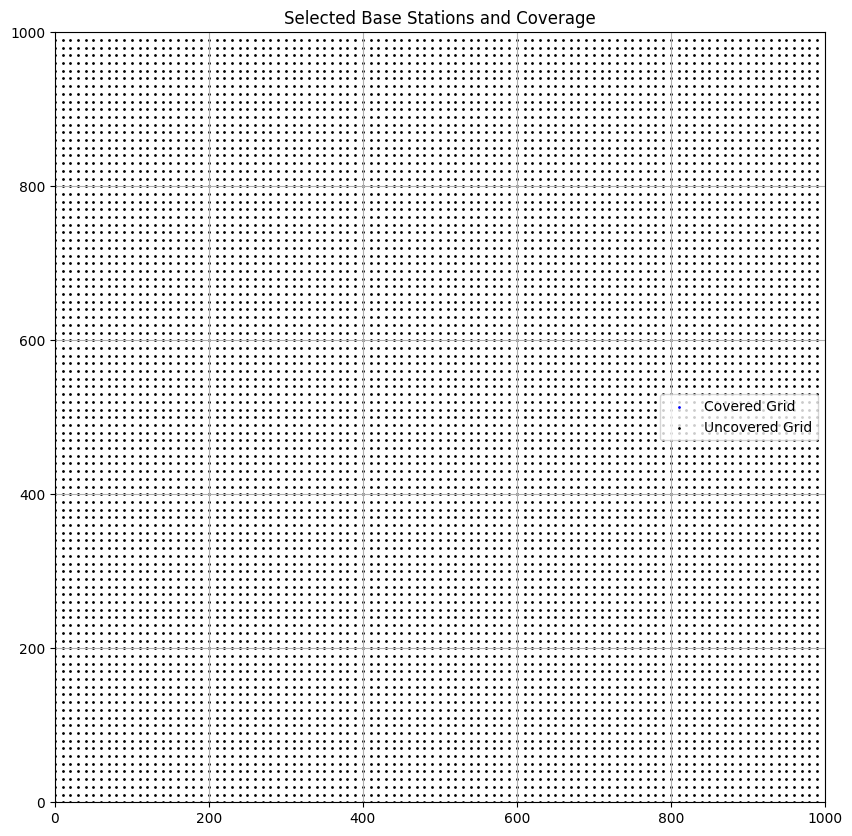

커버된 격자점 수: 0 / 10000
선택된 기지국 인덱스: []
커버율: 0.00%
일부 영역이 커버 X


In [10]:
import matplotlib.pyplot as plt
from torch_scatter import scatter_add

# 1. 좌표 추출
base_coords = data.x[:data.num_base_stations, :2].cpu().numpy()
base_radii = data.x[:data.num_base_stations, 2].cpu().numpy()
grid_coords = data.x[data.num_base_stations:, :2].cpu().numpy()

# 2. 선택된 기지국 확률 > 0.5 기준
with torch.no_grad():
    prob = trained_model(data.x, data.edge_index, data.node_type)
    selected = (prob > 0.6).float()
    selected_indices = selected.nonzero(as_tuple=True)[0].cpu().numpy()

# 3. 선택된 기지국으로 grid 커버 계산
selected_prob = prob * selected.to(prob.device)

base_indices = data.edge_index[0]
grid_indices = data.edge_index[1] - data.num_base_stations

# 선택된 기지국의 확률만 반영
edge_weights = selected_prob[base_indices]
grid_coverage = scatter_add(edge_weights, grid_indices, dim=0, dim_size=data.num_grids)
grid_coverage = grid_coverage.clamp(max=1.0).cpu().numpy()

# 4. 커버 시각화
plt.figure(figsize=(10, 10))

# 커버된 격자점: 파란색 / 안 된 격자점: 검정색
covered_mask = grid_coverage >= 0.5
plt.scatter(grid_coords[covered_mask][:, 0], grid_coords[covered_mask][:, 1], s=1, color='blue', label="Covered Grid")
plt.scatter(grid_coords[~covered_mask][:, 0], grid_coords[~covered_mask][:, 1], s=1, color='black', label="Uncovered Grid")

# 선택된 기지국 시각화
for idx in selected_indices:
    bx, by = base_coords[idx]
    br = base_radii[idx]
    plt.scatter(bx, by, color='red', s=100, label='Selected Base Station' if idx == selected_indices[0] else "")
    circle = plt.Circle((bx, by), br, color='red', alpha=0.15)
    plt.gca().add_patch(circle)

plt.legend()
plt.title("Selected Base Stations and Coverage")
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

# 커버된 격자점 수 계산
num_covered = (grid_coverage >= 0.5).sum()
num_total = data.num_grids
coverage_ratio = num_covered / num_total

print(f"커버된 격자점 수: {num_covered} / {num_total}")
print(f"선택된 기지국 인덱스: {selected_indices.tolist()}")
print(f"커버율: {coverage_ratio:.2%}")


if coverage_ratio >= 1.0:
    print("모든 영역이 커버 O")
else:
    print("일부 영역이 커버 X")



In [11]:
echo "# GNN" >> README.md
git init
git add README.md
git commit -m "first commit"
git branch -M main
git remote add origin https://github.com/Mindong02/GNN.git
git push -u origin main

SyntaxError: invalid syntax (653016246.py, line 1)